In [20]:
import numpy as np 
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from LSTM.PytorchLSTMTrain import LSTMModel
from Transformer.autoregressiveTrain import MotorTransformer 
from IPython.display import clear_output
import time


In [11]:
#useful functions 
def train(model,loader,n_epochs,start_channel,end_channel,window,sched,filename):
    scheduler=np.arange(0,0.9,0.9/(n_epochs))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    history=[]
    for epoch in range(n_epochs):
        total_loss = 0.0
        for (X,) in loader:     # X: (batch, seq_len, input_dim)
            X = X.to(device)
            optimizer.zero_grad()
            seq_len=X.shape[1]
            hidden = None                   # LSTM hidden state
            losses = []
            #predict each future step autoregressively
            inp = X[:, :window,start_channel:end_channel]
            for t in range(window, seq_len):
                # Forward pass
                pred=model(inp)  # (batch,1,12)

                # Compute target delta
                target= X[:, t-window+1:t+1, :12]
                #target_delta = X[:, t-window+1:t+1, :12] - X[:, t-window:t, :12]
                #target_delta = target_delta.unsqueeze(1)  # (batch,1,12)
                losses.append(criterion(pred, target))

                # Reconstruct absolute motor positions
                motors = pred#inp[:, :, :12] + pred
                # Scheduled sampling
                if np.random.random() < scheduler[epoch] and sched:
                    if start_channel<12:
                        remainder = X[:, t-window+1:t+1, 12:end_channel]
                        inp = torch.cat([motors.detach(), remainder.to(device)], dim=2)
                    else: inp= X[:, t-window+1:t+1, start_channel:end_channel]
                else:
                    inp = X[:, t-window+1:t+1, start_channel:end_channel]


            loss = torch.stack(losses).mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
            #clear_output(wait=True)
            #print(f"Live Loss: {total_loss:.6f}")
        avg_loss = total_loss / len(loader)
        clear_output(wait=True)
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.6f} | Probability:"+str(scheduler[epoch]*sched))
        history.append(avg_loss)
    torch.save(model.state_dict(), filename+"_model")
    history=np.array(history)
    np.save(filename+"loss",history)
    return history

## Loss
Train a bunch of models normally and save the loss, then average and show 

In [12]:
X=np.load("/its/home/drs25/Quadruped/Code/UBERMODEL/models/X_sorted.npy")
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
WINDOW=15
for trial in range(20):
    loader = DataLoader(dataset, batch_size=128, shuffle=True)
    INPUT_DIM=X_tensor.shape[2]
    OUTPUT_DIM=12
    model = LSTMModel(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM).to(device)
    train(model,loader,500,0,20,WINDOW,1,"/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/LSTMtrial_"+str(trial))

for trial in range(20):
    loader = DataLoader(dataset, batch_size=128, shuffle=True)
    INPUT_DIM=X_tensor.shape[2]
    OUTPUT_DIM=12
    model = MotorTransformer(input_dim=INPUT_DIM,output_dim=OUTPUT_DIM,T=WINDOW).to(device)
    train(model,loader,500,0,20,WINDOW,1,"/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/TRANStrial_"+str(trial))

Epoch 466 | Loss: 14.797343 | Probability:0.837


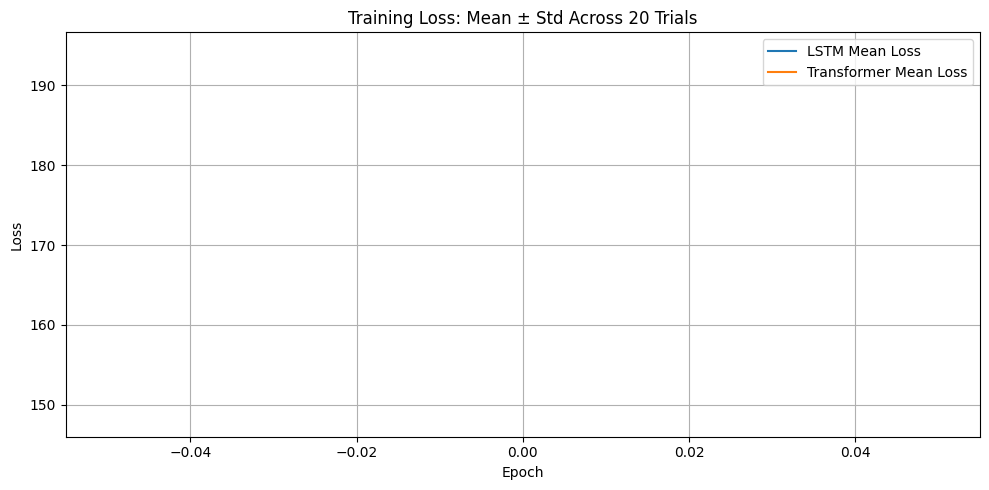

In [21]:
LSTM_LOSS=[]
TRANS_LOSS=[]
for trial in range(20):
    f1="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/LSTMtrial_"+str(trial)+"loss"
    f2="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/TRANStrial_"+str(trial)+"loss"
    loss_lstm=np.load(f1+".npy")
    loss_trans=np.load(f2+".npy")
    LSTM_LOSS.append(loss_lstm)
    TRANS_LOSS.append(loss_trans)

LSTM_LOSS=np.array(LSTM_LOSS)
TRANS_LOSS=np.array(TRANS_LOSS)

lstm_mean = LSTM_LOSS.mean(axis=0)
lstm_std  = LSTM_LOSS.std(axis=0)
trans_mean = TRANS_LOSS.mean(axis=0)
trans_std  = TRANS_LOSS.std(axis=0)
epochs = np.arange(len(lstm_mean))
plt.figure(figsize=(10,5))
plt.plot(epochs, lstm_mean, label="LSTM Mean Loss")
plt.fill_between(epochs, lstm_mean - lstm_std, lstm_mean + lstm_std, alpha=0.2)
plt.plot(epochs, trans_mean, label="Transformer Mean Loss")
plt.fill_between(epochs, trans_mean - trans_std, trans_mean + trans_std, alpha=0.2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss: Mean ± Std Across 20 Trials")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Useful data
Train various models on different parts of the data 
- motors only
- all signals
- tactile vectors and friction only
Plot the data in a table 

In [22]:
X=np.load("/its/home/drs25/Quadruped/Code/UBERMODEL/models/X_sorted.npy")
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
WINDOW=15
config=[[0,12],[12,20]]
for trial in range(20):
    for i,conf in enumerate(config):
        loader = DataLoader(dataset, batch_size=128, shuffle=True)
        INPUT_DIM=conf[1]-conf[0]
        OUTPUT_DIM=12
        model = LSTMModel(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM).to(device)
        train(model,loader,1,conf[0],conf[1],WINDOW,1,"/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/useful data/LSTMtrial_"+str(trial)+"_"+str(i))

for trial in range(20):
    for i,conf in enumerate(config):
        loader = DataLoader(dataset, batch_size=128, shuffle=True)
        INPUT_DIM=conf[1]-conf[0]
        OUTPUT_DIM=12
        model = MotorTransformer(input_dim=INPUT_DIM,output_dim=OUTPUT_DIM,T=WINDOW).to(device)
        train(model,loader,1,conf[0],conf[1],WINDOW,1,"/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/useful data/TRANStrial_"+str(trial)+"_"+str(i))

Epoch 01 | Loss: 275.414948 | Probability:0.0


In [ ]:
LSTM_conf1=[]
LSTM_conf2=[]
LSTM_conf3=[]
TRANS_conf1=[]
TRANS_conf2=[]
TRANS_conf3=[]
#follow order of bullet points above
for trial in range(20):
    f1="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/LSTMtrial_"+str(trial)+"loss"
    f2="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/TRANStrial_"+str(trial)+"loss"
    loss_lstm=np.load(f1+".npy")
    loss_trans=np.load(f2+".npy")
    LSTM_conf2.append(loss_lstm)
    TRANS_conf2.append(loss_trans)
    f1="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/LSTMtrial_"+str(trial)+"_0loss"
    f2="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/TRANStrial_"+str(trial)+"_0loss"
    loss_lstm=np.load(f1+".npy")
    loss_trans=np.load(f2+".npy")
    LSTM_conf1.append(loss_lstm)
    TRANS_conf1.append(loss_trans)
    f1="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/LSTMtrial_"+str(trial)+"_1loss"
    f2="/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/loss/TRANStrial_"+str(trial)+"_1loss"
    loss_lstm=np.load(f1+".npy")
    loss_trans=np.load(f2+".npy")
    LSTM_conf3.append(loss_lstm)
    TRANS_conf3.append(loss_trans)

## Dataset size 
Look at model performance depending on dataset size and diversity of dataset

In [23]:
X=np.load("/its/home/drs25/Quadruped/Code/UBERMODEL/models/X_sorted.npy")

WINDOW=15
config=[i for i in range(100,len(X),2000)]
for trial in range(20):
    for i,conf in enumerate(config):
        X_tensor = torch.tensor(X, dtype=torch.float32)[:100]
        dataset = TensorDataset(X_tensor)
        loader = DataLoader(dataset, batch_size=128, shuffle=True)
        INPUT_DIM=X_tensor.shape[2]
        OUTPUT_DIM=12
        model = LSTMModel(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM).to(device)
        train(model,loader,1,0,20,WINDOW,1,"/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/dataset size/LSTMtrial_"+str(trial)+"_"+str(i))

for trial in range(20):
    for i,conf in enumerate(config):
        X_tensor = torch.tensor(X, dtype=torch.float32)[:100]
        dataset = TensorDataset(X_tensor)
        loader = DataLoader(dataset, batch_size=128, shuffle=True)
        INPUT_DIM=X_tensor.shape[2]
        OUTPUT_DIM=12
        model = MotorTransformer(input_dim=INPUT_DIM,output_dim=OUTPUT_DIM,T=WINDOW).to(device)
        train(model,loader,1,conf[0],conf[1],WINDOW,1,"/its/home/drs25/Quadruped/Code/UBERMODEL/models/experiments/dataset size/TRANStrial_"+str(trial)+"_"+str(i))

Epoch 01 | Loss: 279.389313 | Probability:0.0


KeyboardInterrupt: 

## SImulation performance
Pick the best parameters from above and look at trajectoris and distance as metrics 

: 

## Stat testing 
FInally stat test the model performances of the best paramters from the above experiments

: 